In [5]:
import os
import csv
import cv2
import matplotlib
import pytesseract
import numpy as np
from PIL import Image
from easyocr import Reader
from fuzzywuzzy import fuzz
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
from time import perf_counter as timer

pytesseract.pytesseract.tesseract_cmd = '' # edit to your tesseract path

# shows an image on ipynb
def imshow(img) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

/Users/vs/Documents/GitHub/smoky-mountain-data-comp/.venv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Load the images, read them into the file

In [ ]:
REAL_TEXTS = {}

# get user input on the text in the images
for filename in os.listdir("../sample_dataset"):
    imshow(cv2.imread(f"../sample_dataset/{filename}"))
    REAL_TEXTS[filename] = input()

# go through each image and save the two values in a file
with open("read_texts.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['filename', 'real_text'])
    for row in REAL_TEXTS:
        writer.writerow([row, REAL_TEXTS[row]])

#### Read texts from different OCR models

Define a function for reading the CSV whenever needed

In [18]:
def csv_to_texts():

    # initialize dictionary and parse the file
    read_texts = {}
    with open("read_texts.csv", "r") as f:
        reader = csv.reader(f)

        # go through each row read
        for i, row in enumerate(reader):

            # skip header and blank rows
            if i == 0 or row == []: continue

            # the first value is the filename, rest is texts
            read_texts[row[0]] = row[1:]    

    return read_texts

def texts_to_csv(texts: dict, rows: list[str]):

    # open file for writing (clears everything)
    with open("read_texts.csv", "w") as f:

        # cretae a writer and write the whole thing with the filename first
        writer = csv.writer(f)
        writer.writerow(rows)
        for fname in texts:
            writer.writerow([fname, *texts[fname]])


Read for Pytesseract

In [5]:
# initialize starting values
texts = csv_to_texts()
start = timer()

# read all texts and put into file
for filename in os.listdir("../sample_dataset"):
    img = Image.open(f"../sample_dataset/{filename}")
    texts[filename].append(pytesseract.image_to_string(img))

# save timer in timing file
with open("timer.txt", "a") as f:
    f.write(f"EasyOCR: {timer() - start:.2f} seconds\n")

# write the texts to csv file
texts_to_csv(texts, ['filename', 'real_text', 'pytesseract'])

# example
print([*texts.values()][4][1])

4 -
Fie | . ia
a x A
Ma) ti)

p




Read for EasyOCR

In [ ]:
# initialize the reader
reader = Reader(['en'])

# starting values
texts = csv_to_texts()
start = timer()

# read each text
for filename in os.listdir("../sample_dataset"):
    text_read = reader.readtext(f"../sample_dataset/{filename}")
    text = ''.join([text[1] for text in text_read])
    texts[filename].append(text)

# save the time
with open("timer.txt", "a") as f:
    f.write(f"EasyOCR: {timer() - start:.2f} seconds\n")

# save to file
texts_to_csv(texts, ['filename', 'real_text', 'pytesseract', 'easyocr'])

Read for PaddleOCR

In [17]:
# initialize the reader
reader = PaddleOCR(use_angle_cls=True, lang='en', show_log=False, rotation=True)

# starting values
texts = csv_to_texts()
start = timer()

# read each text file
for filename in os.listdir("../sample_dataset"):
    img = cv2.imread(f"../sample_dataset/{filename}")
    text = ''.join([text[1][0] for text in reader.ocr(img)[0]])
    texts[filename].append(text)

# save the time
with open("timer.txt", "a") as f:
    f.write(f"PaddleOCR: {timer() - start:.2f} seconds\n")

# save the results
texts_to_csv(texts, ['filename', 'real_text', 'pytesseract', 'easyocr', 'paddleocr'])

#### Analyze the results

In [7]:
matplotlib.rcParams["figure.dpi"] = 600

Analyze times

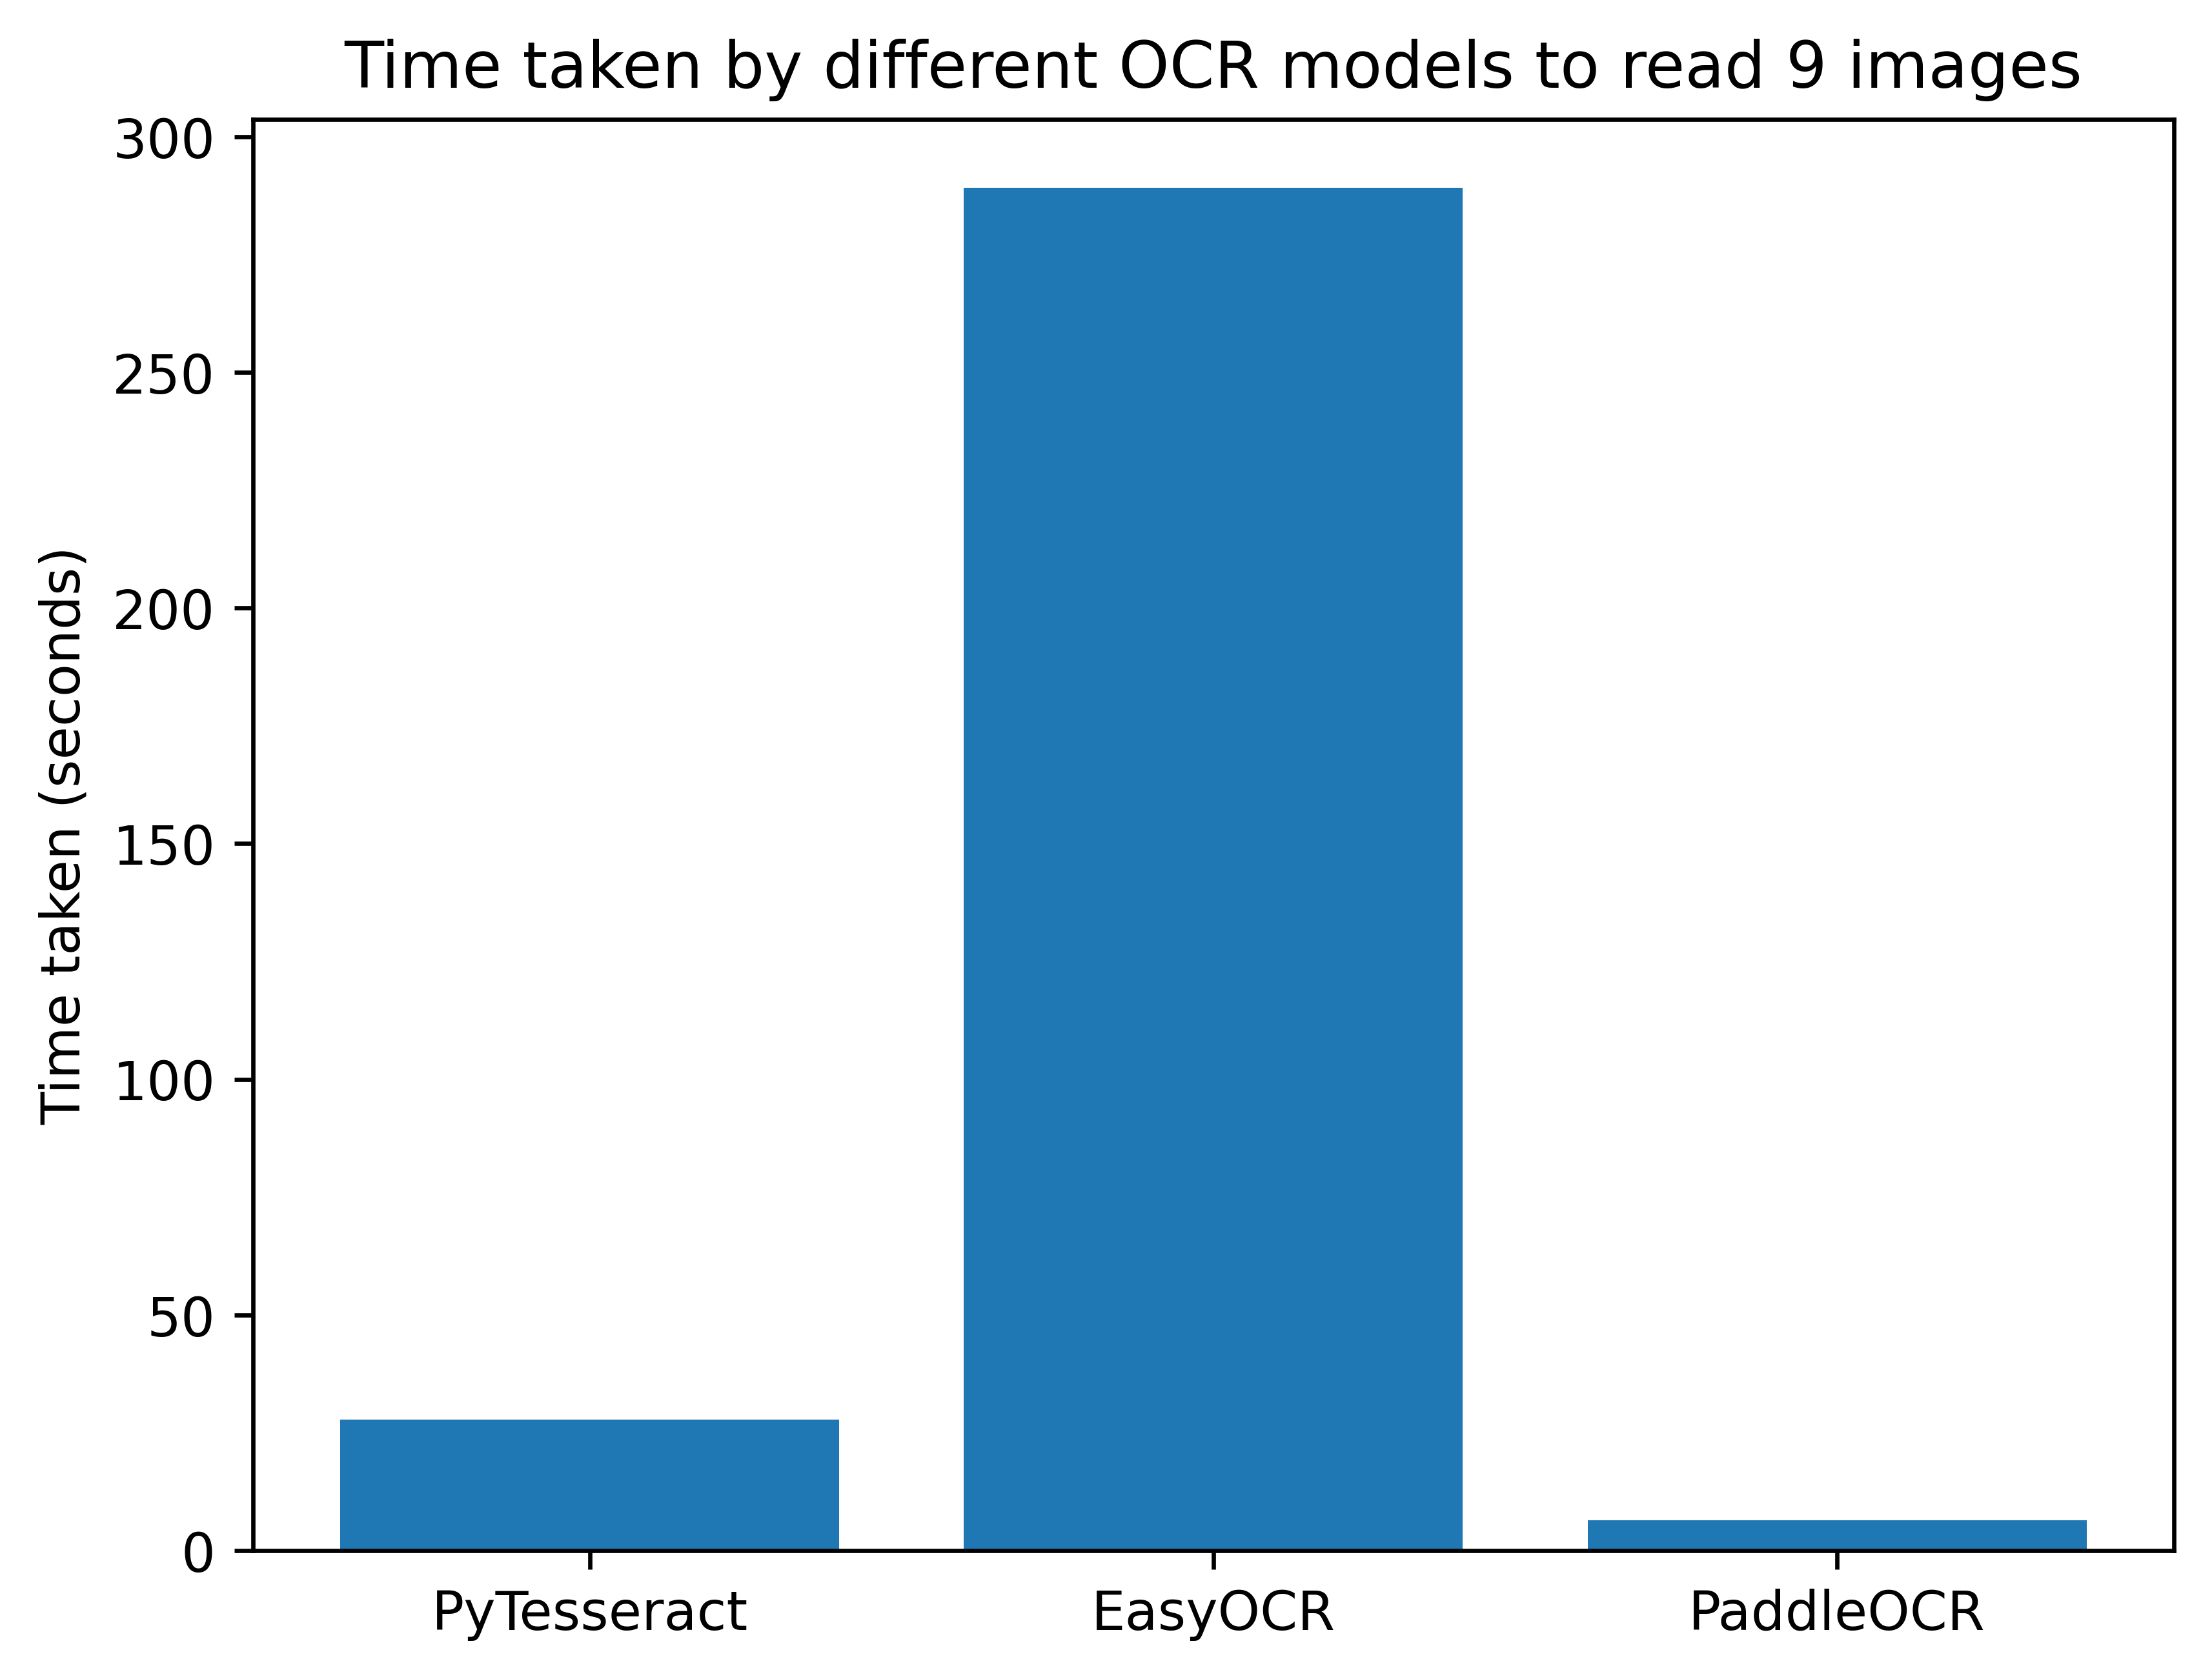

In [8]:
# list of times
labels, times, = [], []
with open("timer.txt", "r") as f:
    for line in f.read().split('\n'):
        label, time = (line.split(': '))
        labels.append(label)
        times.append(float(time.split(' ')[0]))

# get subplots
fig, ax = plt.subplots()

# plot settings
ax.bar(labels, times)
ax.set_ylabel('Time taken (seconds)')
ax.set_title('Time taken by different OCR models to read 9 images')

plt.show()

Analyze accuracy

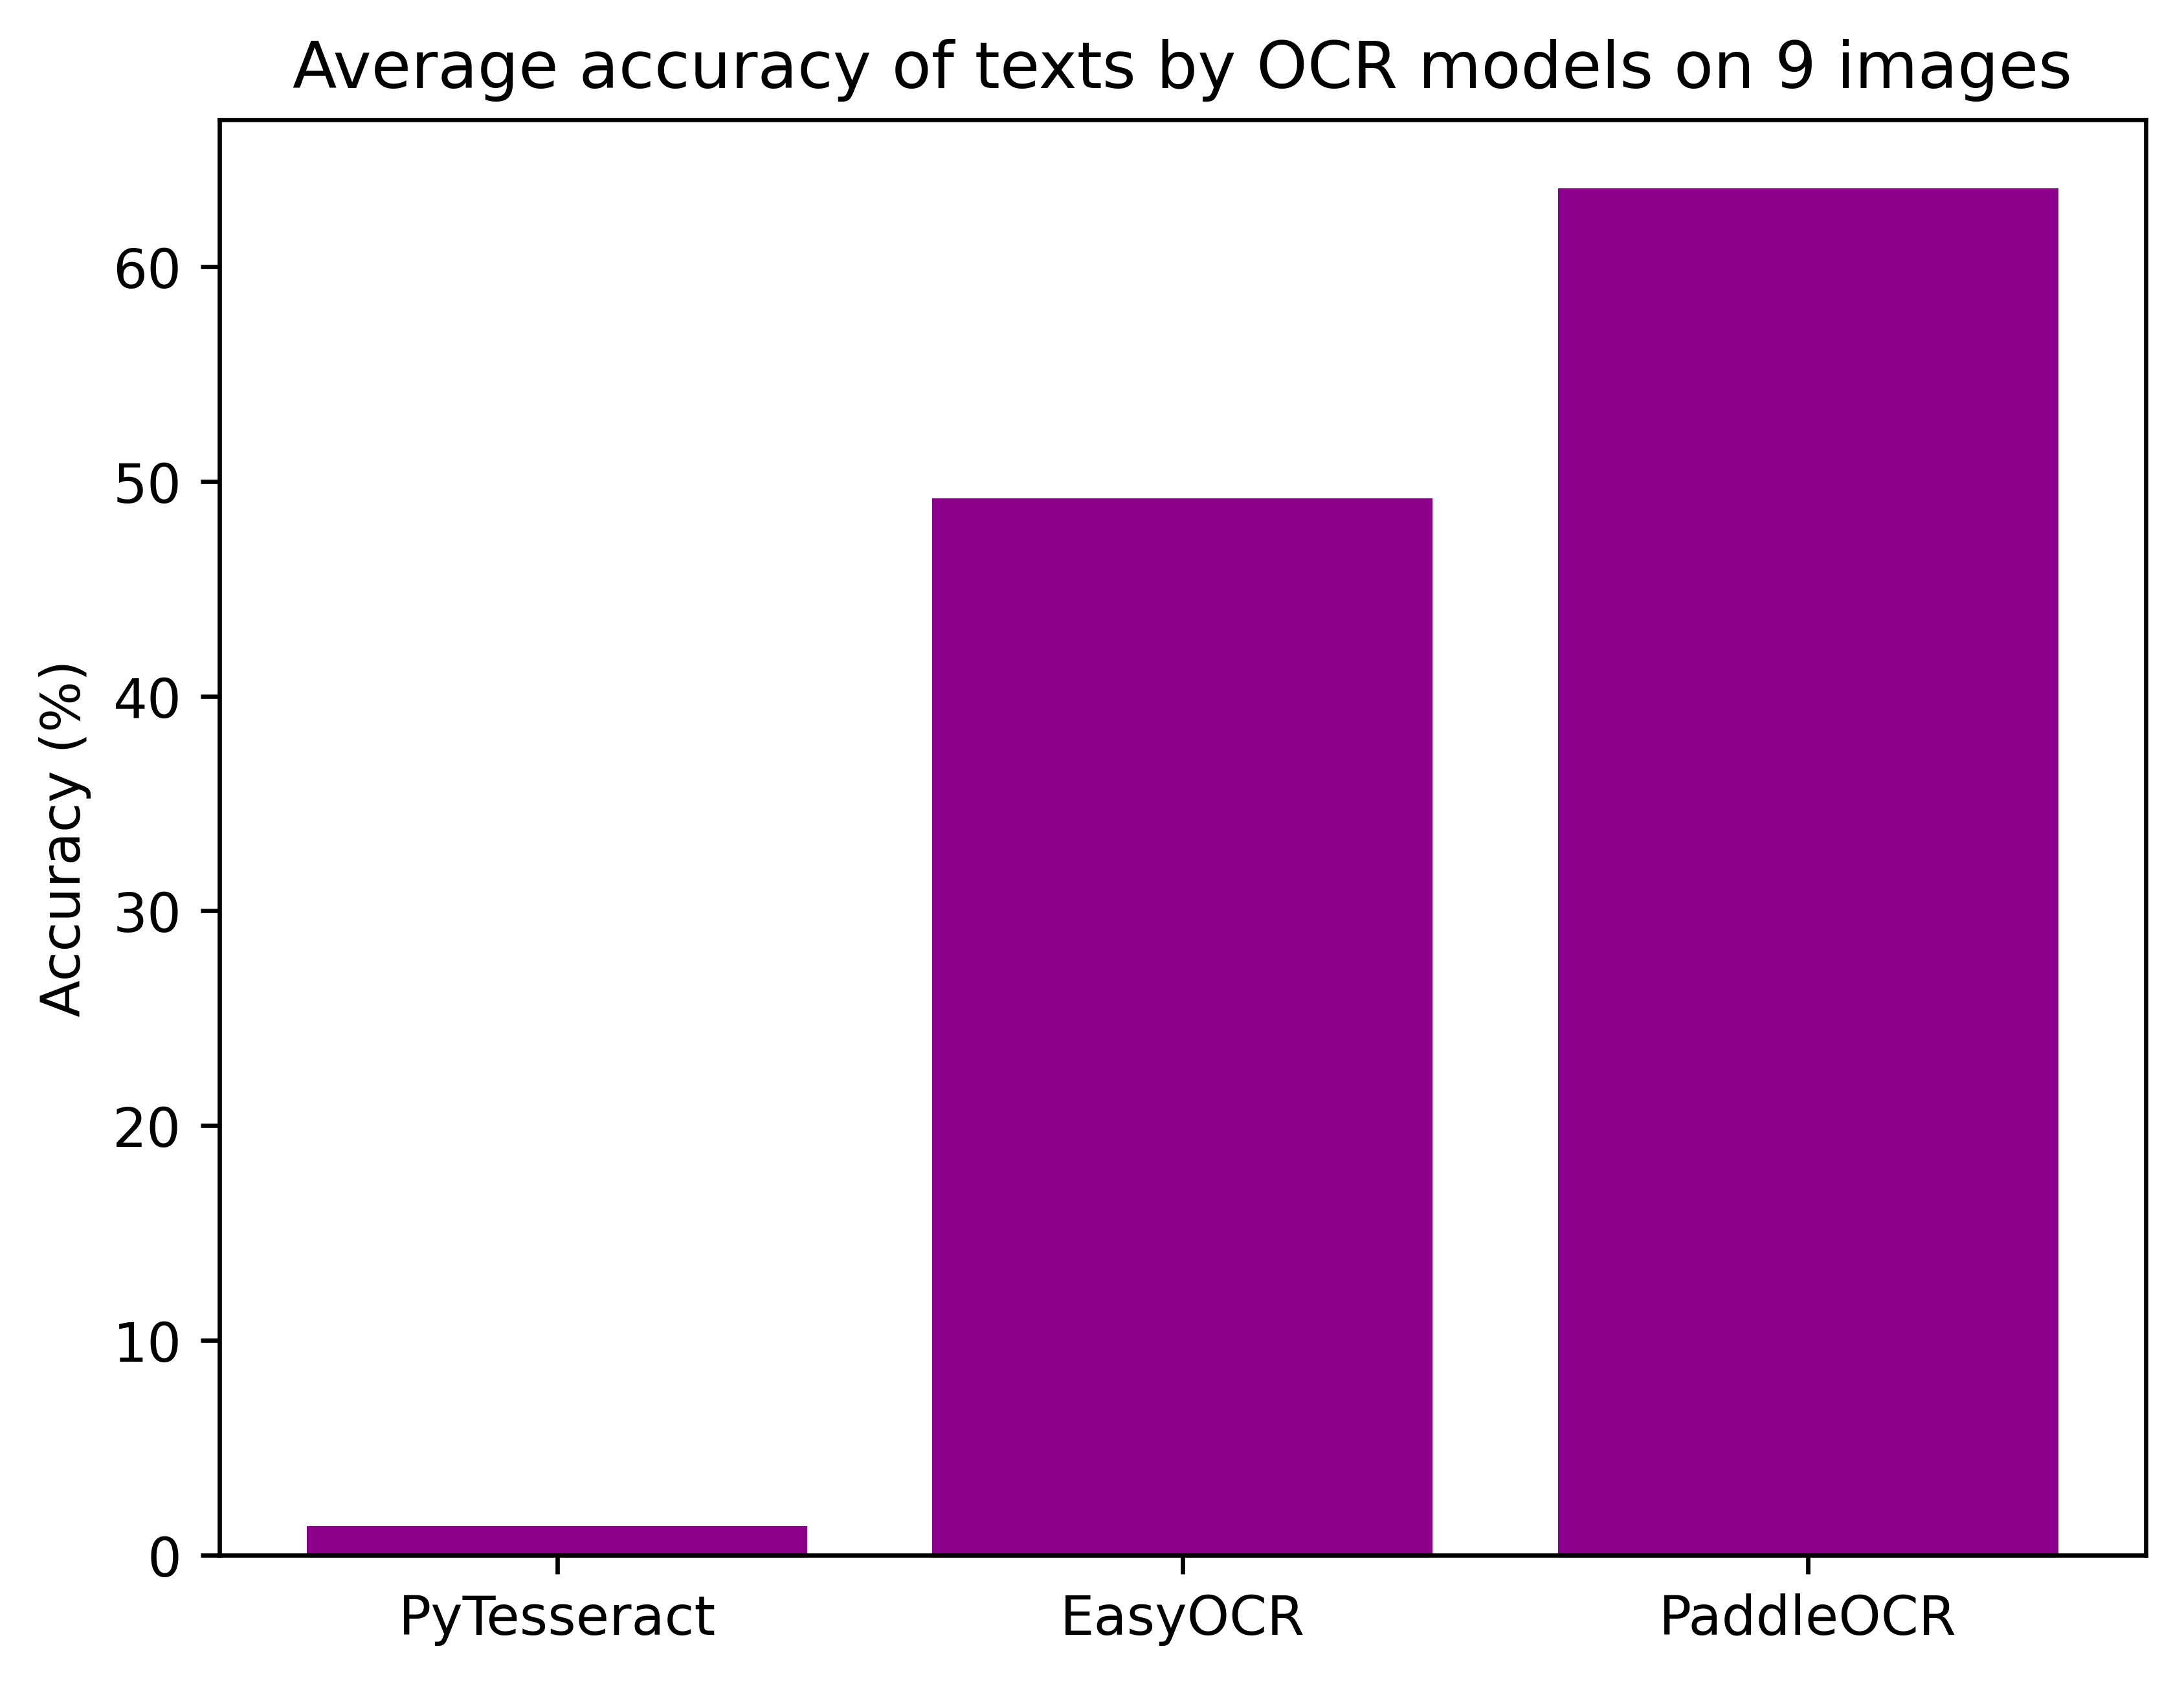

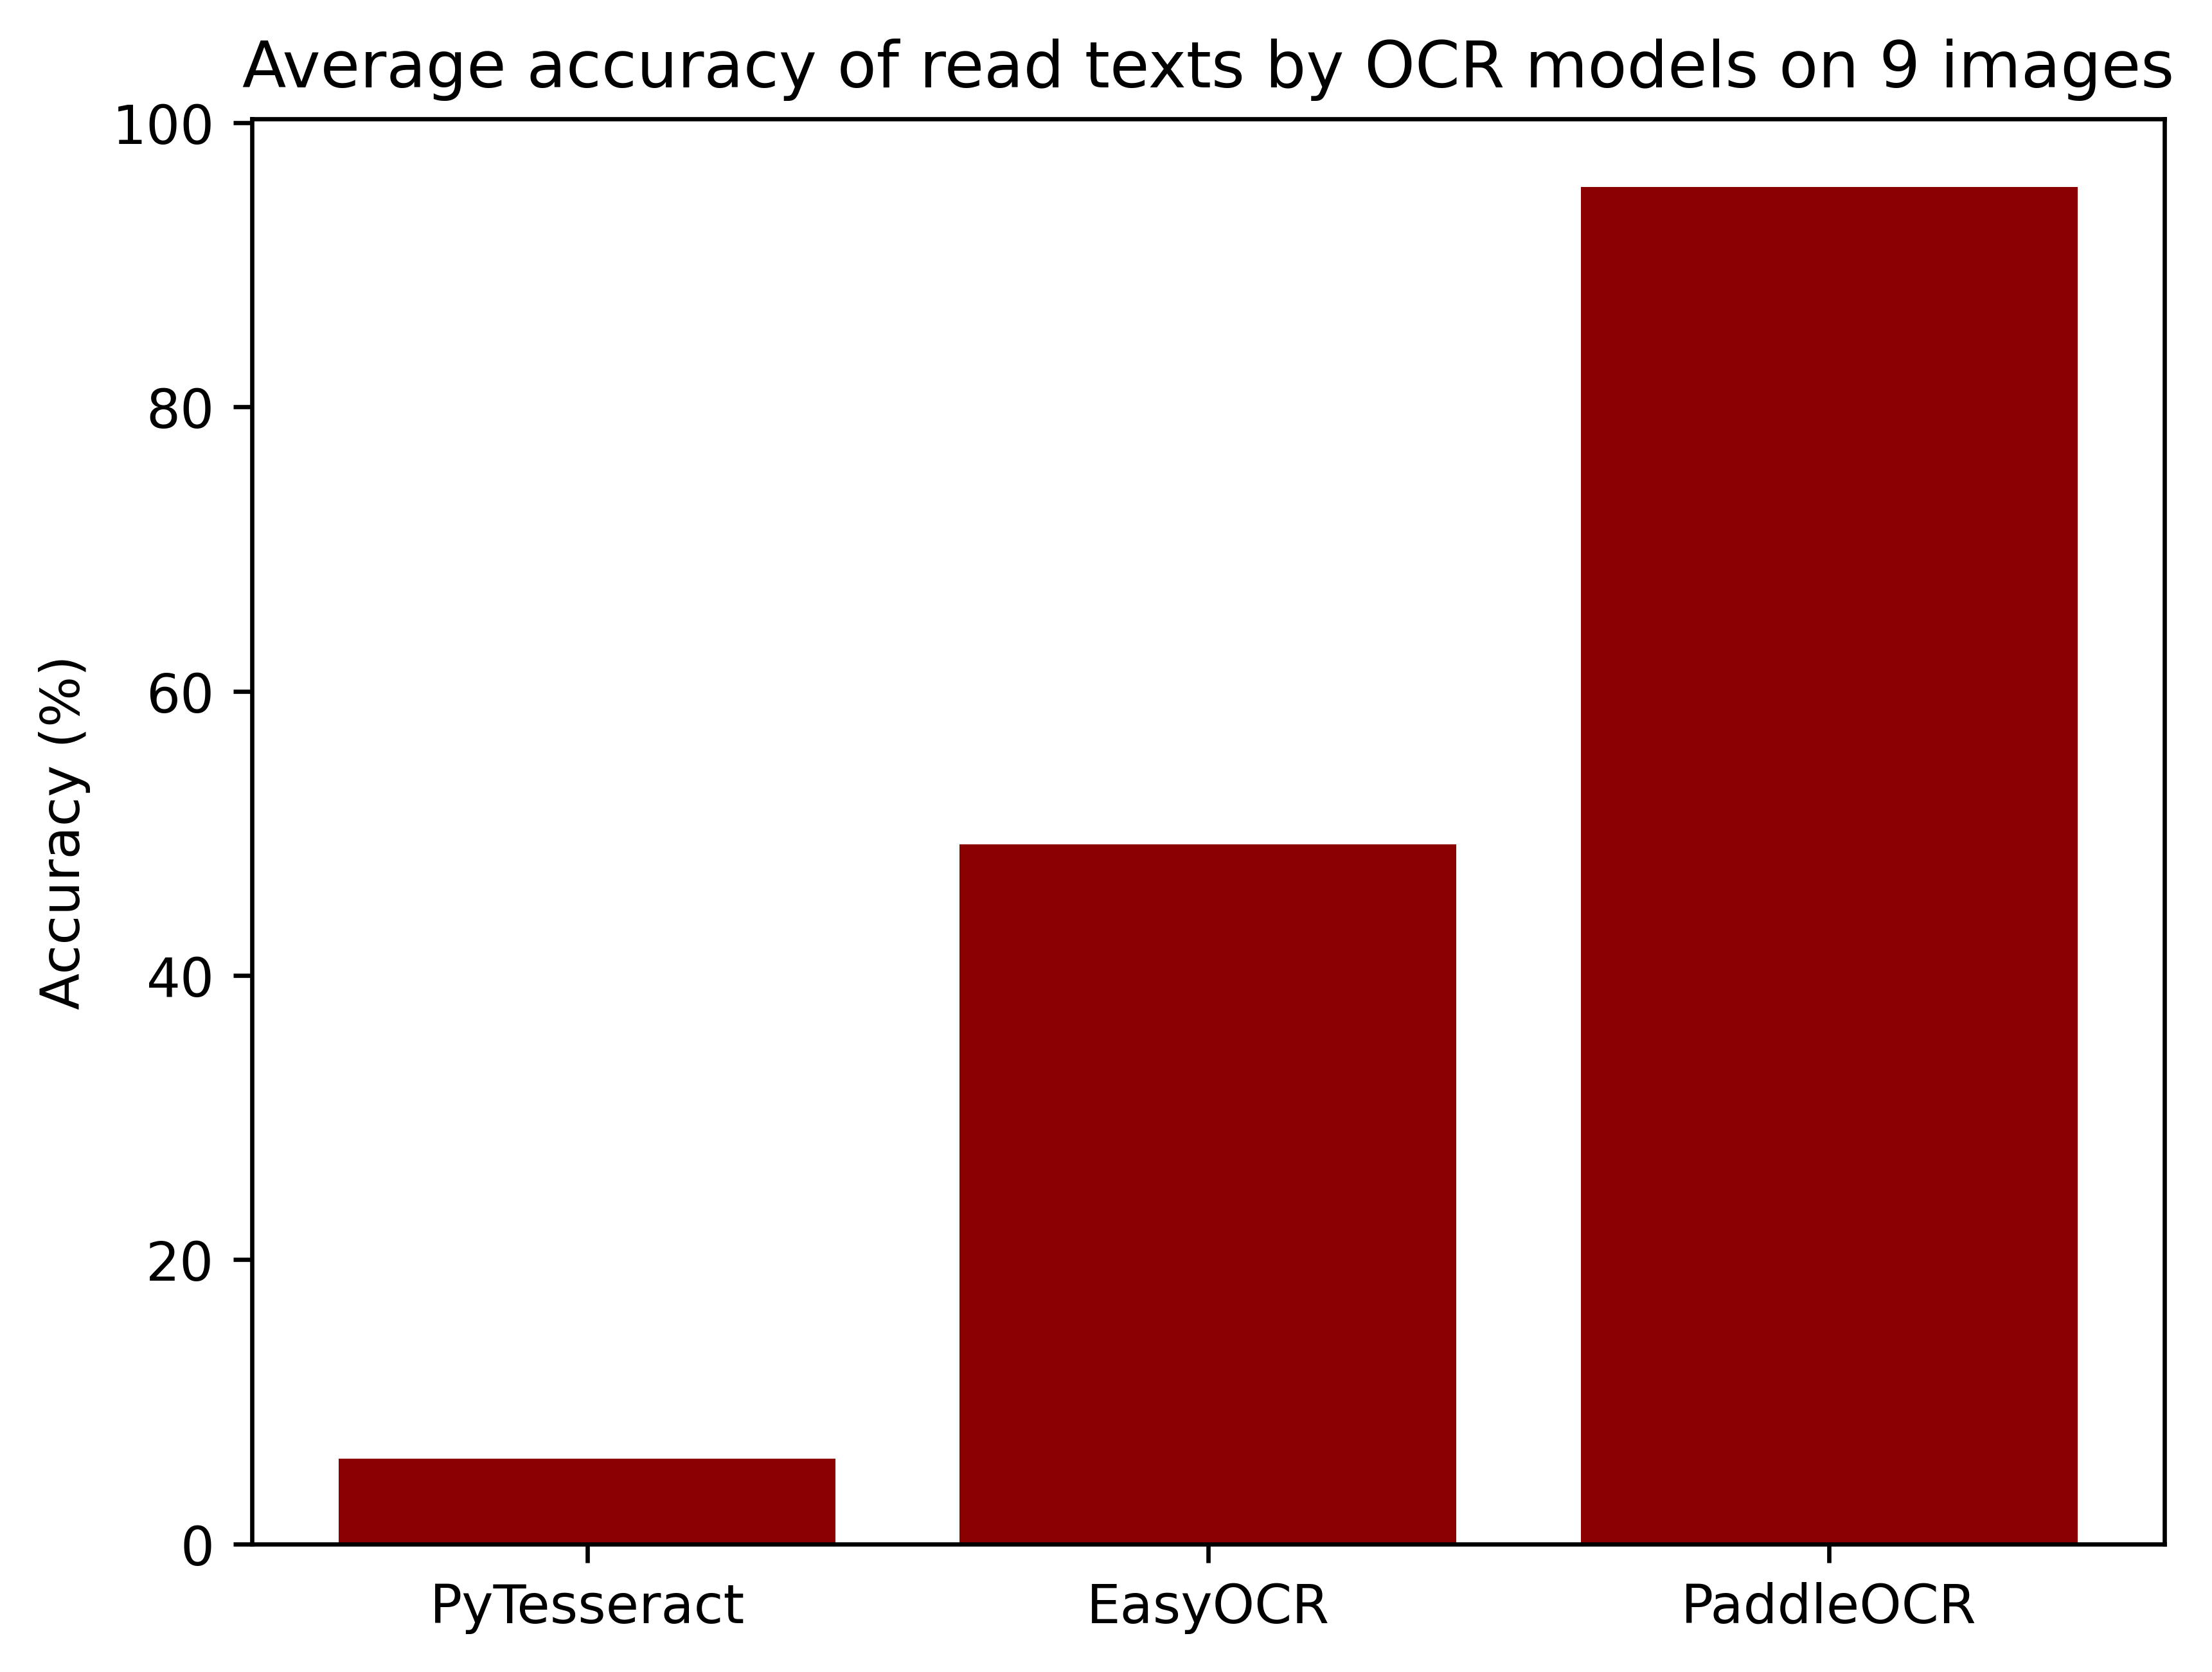

In [6]:
# format texts into array
read_texts = {}
with open("read_texts.csv", "r") as f:
    reader = csv.DictReader(f)
    for d in reader:
        read_texts[d['real_text']] = [
            d['pytesseract'], d['easyocr'], d['paddleocr']
        ]

# get accuracy for each text
accuracies = []
for [real, ocr] in read_texts.items():
    acc_list = []
    for model in ocr:
        acc_list.append(fuzz.ratio(real, model))
    accuracies.append(acc_list)

# get serperated accuracies
accuracies = np.array(accuracies)

# non-pruned (including non-read images)
pytesseract_acc = np.average(accuracies[:, 0])
easyocr_acc = np.average(accuracies[:, 1])
paddle_acc = np.average(accuracies[:, 2])

# plot results
plt.bar(
    ['PyTesseract', 'EasyOCR', 'PaddleOCR'],
    [pytesseract_acc, easyocr_acc, paddle_acc],
    color="darkmagenta"
)
plt.ylabel('Accuracy (%)')
plt.title('Average accuracy of texts by OCR models on 9 images')
plt.show()

# pruned (only read images)
pytesseract_acc_pruned = np.average([i for i in accuracies[:, 0] if i != 0])
easyocr_acc_pruned = np.average([i for i in accuracies[:, 1] if i != 0])
paddle_acc_pruned = np.average([i for i in accuracies[:, 2] if i != 0])

# plot results
plt.bar(
    ['PyTesseract', 'EasyOCR', 'PaddleOCR'],
    [pytesseract_acc_pruned, easyocr_acc_pruned, paddle_acc_pruned],
    color="darkred"
)
plt.ylabel('Accuracy (%)')
plt.title('Average accuracy of read texts by OCR models on 9 images')
plt.show()
